The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


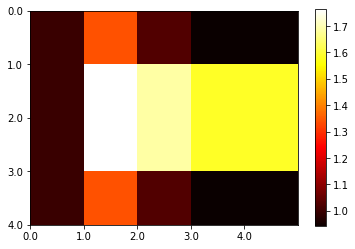

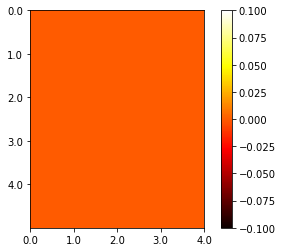

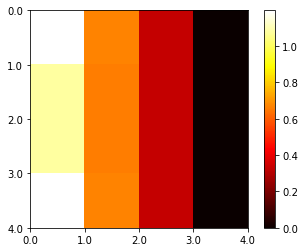

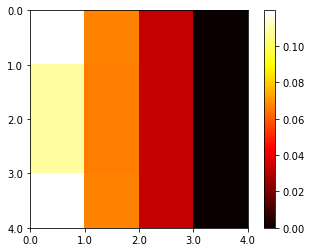

In [16]:
%reset -f
%load_ext autoreload
%autoreload 2

import Odin

from fieldAccess import *
import numpy as np

nx = 4
ny = 4

geom = Odin.createGeometry( 'rectangle', [nx,ny] )
mesh = Odin.createMesh( geom, res=1 )

# make just a list, give a name as optional parameter to flow model
# make this a flowmodeles constructor with kwargs here and then remove simulation instance
myFlowModels = {
    'u' : Odin.TransportModels.staggeredTransport_u,
    'v' : Odin.TransportModels.staggeredTransport_v,
    'p' : Odin.PressureModels.Pressure
}

passiveFields = {}

sim = Odin.Simulation(flowmodels=myFlowModels, mesh=mesh, geometry=geom, passiveFields=passiveFields )

myFields = sim.fieldRegistry
u=myFields['u']
v=myFields['v']
p=myFields['p']

# relates to viscosity:
u.govModel.setDiffusionCoefficient(0.1)
v.govModel.setDiffusionCoefficient(0.1)

u.data.fill(0.5)
Odin.defineBoundaryCondition(field=u, boundaryName='top', type='fixedValue', value=0)
Odin.defineBoundaryCondition(field=u, boundaryName='bottom', type='fixedValue', value=0)
Odin.defineBoundaryCondition(field=u, boundaryName='right', type='zeroGradient')
Odin.defineBoundaryCondition(field=u, boundaryName='left', type='fixedValue', value=1)

v.data.fill(0.0)
Odin.defineBoundaryCondition(field=v, boundaryName='top', type='fixedValue', value=0)
Odin.defineBoundaryCondition(field=v, boundaryName='bottom', type='fixedValue', value=0)
Odin.defineBoundaryCondition(field=v, boundaryName='left', type='fixedValue', value=0 )
Odin.defineBoundaryCondition(field=v, boundaryName='right', type='fixedValue', value=0)

p.data.fill(0)
Odin.defineBoundaryCondition(field=p, boundaryName='top', type='freeFlow')
Odin.defineBoundaryCondition(field=p, boundaryName='bottom', type='freeFlow')
Odin.defineBoundaryCondition(field=p, boundaryName='left', type='freeFlow' )
Odin.defineBoundaryCondition(field=p, boundaryName='right', type='constantPressure', value=0)

#sim.display(u,mesh)

# underRelaxation
alphaP = 0.1
alphaV = 1

#v.govModel.a_p = 1e-8

# preparing the simple loop:
for i in range(1):
    uOld = u.data
    vOld = v.data

    uNew = Odin.solve(u)
    vNew = Odin.solve(v)
    pc = Odin.solve(p)
    #print(pc[0])
    p.data += alphaP*pc

    uNew[internal_u] += p.govModel.d_u[internal_u] * ( pc[west] - pc[east] )
    vNew[internal_v] += p.govModel.d_v[internal_v] * ( pc[north] - pc[south] )

    # correcting internal:
    u.data = alphaV*uNew + (1-alphaV)*uOld
    #v.data = alphaV*vNew + (1-alphaV)*vOld
    #v.data[internal_v] += p.govModel.d_v[internal_v] * ( pc[south]- pc[north])

    # correcting boundaries:  Can I not set them algorithmically? this is not nice
    u.data[boundary_east] = u.data[boundary_nb1_east]
    #v.data[boundary_east] = v.data[boundary_nb1_east]

sim.display(u,mesh)
sim.display(v,mesh)
sim.display(pc,mesh)
sim.display(p,mesh)
#sim.display(v,mesh)
#sim.display(p,mesh)
#
#
# print(p.govModel.linSystem.A)
# print(p.govModel.linSystem.b)

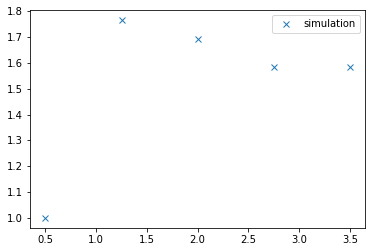

[1.         1.76467996 1.69054993 1.58535733 1.58535733]


In [17]:

# post-processing:
import numpy as np
import matplotlib.pyplot as plt

nbcellsX = sim.mesh.cells_x
cellSpacing = sim.mesh.uniformSpacing
LenX = geom.lenX

xSim = np.linspace(0+0.5*cellSpacing,LenX-0.5*cellSpacing,nbcellsX+1)
ySim = u.data[ny//2 ,:]

# xTheo = np.linspace(0,LenX, 100)
# S = np.ones(len(xTheo))*heatSource
# yTheo = tempDistr(xTheo)

ax = plt.gca()
ax.plot(xSim, ySim, 'x', label='simulation')
#ax.plot(xTheo, yTheo, label='theoretical')

plt.legend()
plt.show()

print(ySim)


In [ ]:
# shutting the interpreter down, so I can a fresh instance next time.
# my modules are automatically checked for updates
import os
os._exit(00)